# Anlaysis of output from SDE simulations of dynverse networks


Load necessary libraries

In [7]:
from __future__ import unicode_literals
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as line
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)

import matplotlib.patches as patches
%matplotlib inline

from tqdm import tqdm
#import emoji
plt.rcParams["font.size"] = 12

In [ ]:
# intialize color palette
pale = [(0.8274509803921568, 0.1843137254901961, 0.1843137254901961),
 (0.1803921568627451, 0.49019607843137253, 0.19607843137254902),
 (0.1803921568627451, 0.25098039215686274, 0.3254901960784314),
 (0.5568627450980392, 0.1411764705882353, 0.6666666666666666),
 (0.4745098039215686, 0.3333333333333333, 0.2823529411764706),
 (0.47058823529411764, 0.5647058823529412, 0.611764705882353),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.0, 0.7568627450980392, 0.7294117647058823),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.2235294117647059, 0.28627450980392155, 0.6705882352941176),
 (1.0, 0.7019607843137254, 0.0)]


In [66]:
def violinPlot(inputDF, yLabel = 'AUROC', randValue = 0.5, ylim = (0,1)):
    plt.figure(figsize =(15,6))
    inputDF = inputDF[inputDF.mean(axis='rows').sort_values().index]
    
    # Flatten the matrix
    PRModified = pd.melt(inputDF, id_vars=inputDF.index, value_vars=inputDF.columns)

    PRModified.loc[:,'nCells'] = [str(x.split('_')[1]) for x in PRModified.columns[:-2]]*inputDF.shape[1]

    ax = sns.lineplot(y = randValue,x = inputDF.columns)
    ax.lines[0].set_linestyle("--")
    ax.lines[0].set_color("gray")
    ax = sns.violinplot(y='value',x ='variable', data=PRModified,
                        inner = None,color='0.8')
    outDF = pd.read_csv('outputs/dyn-BF/dyn-BF-uAUPRCscores.csv', index_col = 0, header = 0)

    ax = sns.stripplot(y="value", x="variable", data=PRModified, jitter=True,
                       hue='nCells',palette=[pale[0],pale[10],pale[9]],size = 6)


    ax.set_ylim([ylim[0],ylim[1]])
    ax.set_xlabel('Algorithm')
    ax.set_ylabel(yLabel)


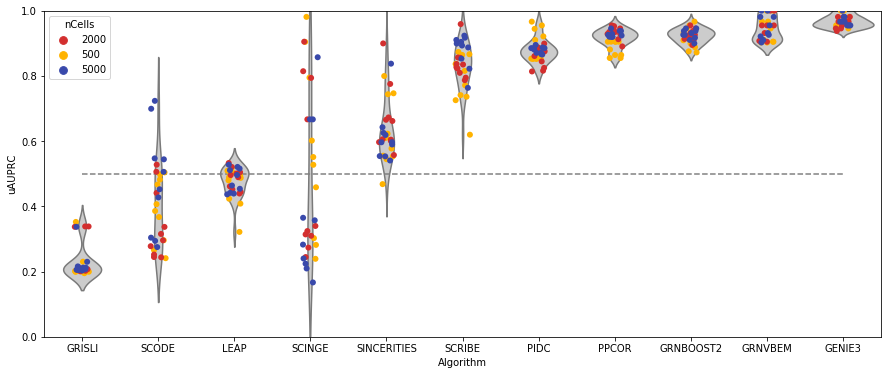

In [248]:
outDF = pd.read_csv('outputs/dyn-LI/dyn-LI-uAUPRCscores.csv', index_col = 0, header = 0)
violinPlot(outDF.T, ylim=(0.0,1), yLabel = 'uAUPRC')

/home/adyprat/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


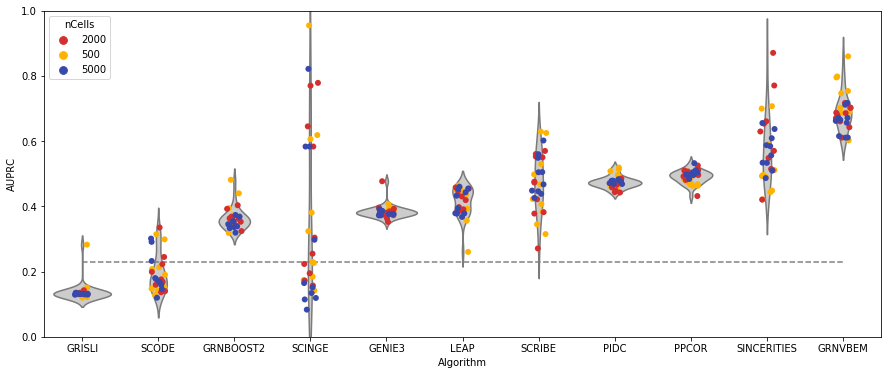

In [247]:
outDF = pd.read_csv('outputs/dyn-LI/dyn-LI-AUPRCscores.csv', index_col = 0, header = 0)
violinPlot(outDF.T, ylim=(0.0,1), yLabel='AUPRC',randValue = 0.23)

Initialize list of trajectories
- 'LI': Linear
- 'CY': Cycle
- 'LL': Linear Long
- 'BF': Bifurcating
- 'BFC': Bifurcating Converging
- 'TF': Trifurcating

In [73]:
def fancyDF(inputDF, height = 7, randValues = [], shape = [], 
            palettes = [], text = [], levels = [], rotation = [],
            colfigures={},zoom=0.2): 
    levls = levels
    print(levls)
    rowNames = inputDF.index
    maxRows = len(inputDF.index)
    maxCols = len(inputDF.columns)
    pad = 2
    aspRatio = (maxCols+pad)/(maxRows+pad)
    fSize = (height*aspRatio,height)

    f = plt.figure(figsize=fSize)

    
    ax = plt.gca()
    ax.set_yticks(np.arange(0,maxRows+pad))
    ax.set_xticks(np.arange(0,maxCols+pad))
    

    Indices = [""] + list(rowNames)  +  [""]
    ax.set_yticklabels(Indices)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    aspRatio = fSize[0]/fSize[1]
    print(aspRatio)
    alt = True
    for rowIdx in range(len(rowNames)):
        if alt:
            ptch = patches.Rectangle((0,rowIdx+0.5),
                               width = maxCols + 1,
                               height = 1,  
                               edgecolor = (1,1,1),
                               facecolor = (0.9,0.9,0.9),)

        else:
            ptch = patches.Rectangle((0,rowIdx+0.5),
                   width = maxCols,
                   height = 1,  
                   edgecolor = (1,1,1),
                   facecolor = (1,1,1),)
        alt = not(alt)
        ax.add_artist(ptch)

    colCnt = 0
    for levlIdx in range(len(levls)):
        randValue = randValues[levlIdx]
        colStart = colCnt
        plt.text(colStart+2, maxRows + 2, 
                        levls[levlIdx], size=12, rotation=0,
                        ha="center", va="center", bbox=dict(boxstyle="round",
                        ec=(1,1,1), fc=(1,1,1)))
        
        colNames = inputDF[levels[levlIdx]].columns

        for colIdx in range(len(colNames)):
                colCnt += 1
                if levls[levlIdx] in colfigures.keys() and colNames[colIdx] in colfigures[levls[levlIdx]].keys():
                    img = plt.imread(colfigures[levls[levlIdx]][colNames[colIdx]],format='png')
                    imagebox = OffsetImage(img,zoom=zoom)
                    imagebox.image.axes = ax
                    xy = (colStart + colIdx + 1,maxRows+1)
                    ab = AnnotationBbox(imagebox,xy=xy,
                                        xycoords='data',frameon=False)
                    ax.add_artist(ab)
                else:
                    plt.text(colStart + colIdx + 1, maxRows + 1, colNames[colIdx],
                             size=10, rotation=rotation[levlIdx],
                             ha="center", va="center",
                             bbox=dict(boxstyle="round",
                                       ec=(1,1,1,0),
                                       fc=(1,1,1,0)))
                for rowIdx in range(len(rowNames)):

                    value  =  inputDF.loc[rowNames[rowIdx],levls[levlIdx]][colNames[colIdx]]
                    if text[levlIdx]:
                        if value == 'Y':
                            txt = '\u2713'
                            col = 'g'
                        elif value == 'N':
                            txt = '\u2717'
                            col = 'r'
                        else:
                            txt = value
                            col = 'k'
                        plt.text(colStart+colIdx+1, rowIdx+1, 
                            txt, size=15, rotation=0,
                            ha="center", va="center", color = col,
                            bbox=dict(boxstyle="round",
                            ec=(1,1,1,0), fc=(1,1,1,0)))
                    
                    if shape[levlIdx] != 'text':
                        if value <= randValue:
                            col = 'k'
                        else:
                            col = palettes[levlIdx][int(np.floor(value*10))]


                        if shape[levlIdx] == 'c':
                            circle1=patches.Ellipse((colStart+colIdx+1,rowIdx+1),
                                               width = value,
                                               height = value,    
                                               facecolor=col,
                                               edgecolor = 'k',)

                        elif shape[levlIdx] == 's':
                            circle1=patches.Rectangle((colStart+colIdx+1-(value/2),rowIdx+1-(value)/2),
                                       width = value,
                                       height = value,    
                                       facecolor=col,
                                       edgecolor = 'k',)

                        elif shape[levlIdx] == 'rs':
                            boxPad = 0.1
                            newVal = value - boxPad*2
                            circle1=patches.FancyBboxPatch((colStart+colIdx+1-(newVal/2),rowIdx+1-(newVal)/2),
                                       width = newVal,
                                       height = newVal,    
                                       facecolor=col,
                                       edgecolor = 'k',
                                       boxstyle=patches.BoxStyle("Round", pad=boxPad))
                                        #patches.BoxStyle("Round4", pad=0.05))
                        elif shape[levlIdx] == 'w':
                            circle1=patches.Wedge((colStart+colIdx+1,rowIdx+1),
                                       r = 0.4,
                                       theta1 = 0,
                                       theta2 = round(value*360,2),    
                                       facecolor=col,
                                       edgecolor = 'k',)
     

                        ax.add_artist(circle1)
                        

    ax.yaxis.set_ticks_position('none') 
    ax.xaxis.set_ticks_position('none') 
    ax.set_xticklabels([])

    #plt.grid()
#PTData = pd.read_csv("outputs/dyn-BF/dyn-BF-AUROCscores.csv", header = 0, index_col = 0)



In [249]:
trajectoryType = ['LI','CY','LL','BF','BFC','TF']
resType = ['AUPRC','AUROC','uAUPRC','uAUROC']
finalDF = {}
for traj in trajectoryType:
    outName = 'dyn-'+traj
    dataDict = {}
    for res in resType:
        inDF = pd.read_csv('outputs/'+outName+'/'+outName+'-'+res+'scores.csv', header = 0,
                          index_col = 0)
    
        dataDict[res] = inDF.median(axis='columns')
    finalDF[traj] = pd.DataFrame(dataDict)


In [94]:

trajectoryType = ['LI','CY','LL','BF','BFC','TF']
resType = ['AUROCscores','uAUROCscores','corrData','Timescores']
resTypeName = ['AUROC (directed)','AUROC (undirected)','Spearman','Time']
dataDict = {}
arrays = [[],[]]

cnt = -1
for res in resType:
    cnt += 1
    for traj in trajectoryType:
        outName = 'dyn-'+traj
    
        inDF = pd.read_csv('outputs/'+outName+'/'+outName+'-'+res+'.csv', header = 0,
                      index_col = 0)
        arrays[0].append(resTypeName[cnt])
        arrays[1].append(traj)

        dataDict[res+'_'+traj] = inDF.median(axis='columns')
    
finalDF2 = pd.DataFrame(dataDict)#, axis='columns')
finalDF2.columns = arrays
#finalDF2 = finalDF2.loc[finalDF2.mean(axis='columns').sort_values().index]
#finalDF2
#dataDict
finalDF2.to_csv("dyn.csv")
finalDF2.head()

AUROC (directed)                                                    \
                        LI        CY        LL        BF       BFC        TF   
GENIE3            0.861224  0.737847  0.942081  0.677344  0.765778  0.602187   
GRISLI            0.408163  0.513889  0.941647  0.483594  0.543333  0.536199   
GRNBOOST2         0.812245  0.788194  0.937018  0.698438  0.776667  0.694570   
GRNVBEM           0.861224  0.470486  0.956935  0.596875  0.644444  0.605204   
LEAP              0.632653  0.552083  0.586613  0.442188  0.561778  0.529035   

          AUROC (undirected)                                 ...    Spearman  \
                          LI        CY        LL        BF   ...          LL   
GENIE3              0.979592  0.851852  0.995473  0.877315   ...    0.496300   
GRISLI              0.163265  0.333333  0.947531  0.335648   ...    0.390332   
GRNBOOST2           0.933673  0.870370  0.984362  0.814815   ...    0.481645   
GRNVBEM             0.948980  0.666667  0.979012  0.599537   ...    0.243555   
LEAP                0.459184  0.666667  0.423148  0.449074   ...    0.383331   

                                            Time                           \
                 BF       BFC        TF       LI      CY       LL      BF   
GENIE3     0.495555  0.493831  0.497141   63.730  52.835  316.300  65.395   
GRISLI     0.268823  0.178547  0.302066   41.770     NaN   61.090  30.980   
GRNBOOST2  0.488014  0.475352  0.482752    9.460  10.995   43.855  16.335   
GRNVBEM    0.382664  0.324765  0.320489   25.195     NaN  859.080  23.360   
LEAP       0.468638  0.384955  0.495208  111.800     NaN  123.780  37.490   

                            
               BFC      TF  
GENIE3     126.530  73.155  
GRISLI      52.740  38.415  
GRNBOOST2   24.935  18.670  
GRNVBEM     28.695  19.690  
LEAP        22.400  32.235  

[5 rows x 24 columns]

In [152]:
finalDF3 = pd.read_csv("Summary-dyn.csv",header=[0,1], index_col = 0,skipinitialspace=True)
finalDF3 = finalDF3.loc[finalDF3.mean(axis='columns').sort_values().index]
finalDF3['Time'] = np.log(finalDF3['Time'])
finalDF3['Time'] = (finalDF3['Time']-finalDF3['Time'].min())/(finalDF3['Time'].max()-finalDF3['Time'].min())
finalDF3

Overview                   AUROC (directed)            \
            PseudoTime? Directed? Signed?               LI        CY   
PPCOR                 N         N       Y         0.826531  0.777778   
SINCERITIES           Y         Y       Y         0.884694  0.302083   
GRNBOOST2             N         Y       N         0.812245  0.788194   
PIDC                  N         N       N         0.810204  0.777778   
GRISLI                Y         Y       N         0.408163  0.513889   
SCRIBE                Y         Y       N         0.755102  0.750000   
SCODE                 Y         Y       Y         0.551020  0.515625   
GENIE3                N         Y       N         0.861224  0.737847   
LEAP                  Y         Y       N         0.632653  0.552083   
GRNVBEM               Y         Y       Y         0.861224  0.470486   
SCINGE                Y         Y       N         0.589796  0.605903   

                                                    AUROC (undirected)  \
                   LL        BF       BFC        TF                 LI   
PPCOR        0.897184  0.750000  0.800000  0.598793           0.905612   
SINCERITIES  0.501784  0.428125  0.428889  0.381976           0.826531   
GRNBOOST2    0.937018  0.698438  0.776667  0.694570           0.933673   
PIDC         0.935667  0.748437  0.715111  0.669683           0.887755   
GRISLI       0.941647  0.483594  0.543333  0.536199           0.163265   
SCRIBE       0.774064  0.621094  0.737333  0.629336           0.846939   
SCODE        0.522521  0.543750  0.538000  0.607089           0.551020   
GENIE3       0.942081  0.677344  0.765778  0.602187           0.979592   
LEAP         0.586613  0.442188  0.561778  0.529035           0.459184   
GRNVBEM      0.956935  0.596875  0.644444  0.605204           0.948980   
SCINGE       0.513310  0.569531  0.600667  0.527526           0.500000   

               ...               Spearman                                \
               ...           TF        LI        CY        LL        BF   
PPCOR          ...     0.680769  0.454832  0.488761  0.433974  0.491734   
SINCERITIES    ...     0.485897  0.339367  0.456185  0.357199  0.181298   
GRNBOOST2      ...     0.742308  0.492880  0.477979  0.481645  0.488014   
PIDC           ...     0.707692  0.472066  0.487593  0.471904  0.498154   
GRISLI         ...     0.432051  0.473559  0.489713  0.390332  0.268823   
SCRIBE         ...     0.661538  0.334492  0.252433  0.268464  0.307413   
SCODE          ...     0.515385  0.186169  0.161728  0.219728  0.180509   
GENIE3         ...     0.779487  0.497825  0.496456  0.496300  0.495555   
LEAP           ...     0.514103  0.423538  0.471318  0.383331  0.468638   
GRNVBEM        ...     0.532051  0.374447  0.438342  0.243555  0.382664   
SCINGE         ...     0.453846  0.234573  0.263753  0.156442  0.229732   

                                     Time                      
                  BFC        TF       500      2000      5000  
PPCOR        0.463870  0.475595  0.000000  0.000000  0.020782  
SINCERITIES  0.285607  0.282543  0.056463  0.152482  0.000000  
GRNBOOST2    0.475352  0.482752  0.345017  0.408099  0.322476  
PIDC         0.474943  0.495931  0.389526  0.441365  0.315788  
GRISLI       0.178547  0.302066  0.459561  0.500267  0.407986  
SCRIBE       0.246103  0.199220  0.497436  0.494844  0.476839  
SCODE        0.230342  0.252914  0.531931  0.559385  0.501705  
GENIE3       0.493831  0.497141  0.627843  0.634742  0.582283  
LEAP         0.384955  0.495208  0.673317  0.577829  0.648316  
GRNVBEM      0.324765  0.320489  0.715830  0.678457  0.685570  
SCINGE       0.164477  0.235274  1.000000  1.000000  1.000000  

[11 rows x 24 columns]

['Overview', 'AUROC (directed)', 'AUROC (undirected)', 'Spearman', 'Time']
2.0


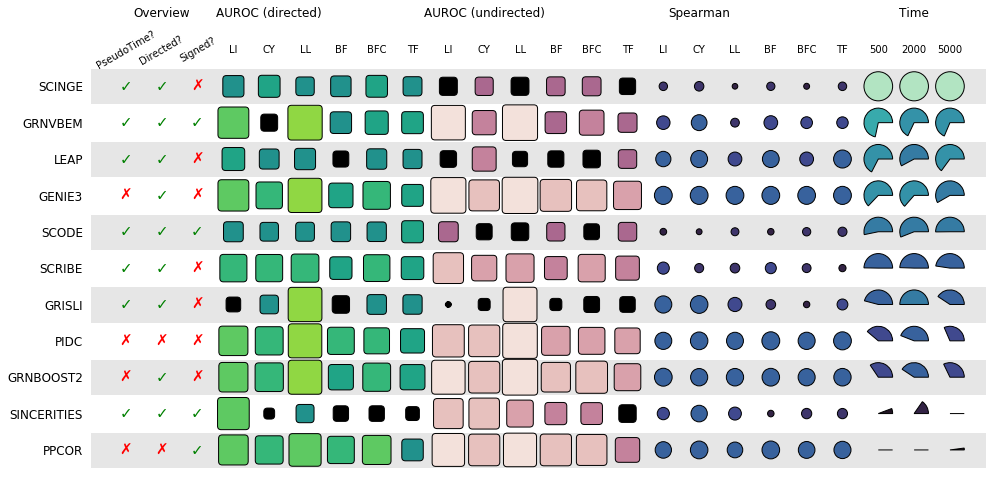

In [154]:
pale = sns.diverging_palette(5, 230, center = 'light', n=10)
pale = sns.color_palette("mako",11)
pale1 = sns.color_palette("viridis",11)
pale2 = sns.cubehelix_palette(11, dark=1, light = 0)
#fancyDF(inputDF, (8,10))
fancyDF(finalDF3, height = 7, randValues = [0, 0.5,0.5,0,0], 
        shape = ['text','rs','rs','c','w'], palettes = [pale2,pale1,pale2,pale,pale],
        text = [True, False, False, False, False], 
        levels = ['Overview','AUROC (directed)','AUROC (undirected)','Spearman','Time'],
        rotation = [30,0,0,0,0])
plt.tight_layout()
plt.savefig("dynSummary.pdf")


In [142]:
dataDict = {}
allnumcells = ['500','2000','5000']
#for nCells in allnumcells:
#    dataDict[nCells] = 0
#dataDict = {{nCells:0 for nCells in allnumcells}}

for traj in trajectoryType:
    outName = 'dyn-'+traj

    inDF = pd.read_csv('outputs/'+outName+'/'+outName+'-Timescores.csv', header = 0,
                  index_col = 0)
    
    inDF.fillna(value = 0, inplace = True)
    cols = {numcells:[col for col in inDF.columns if numcells in col] for numcells in allnumcells}
    for nCells in allnumcells:

        if nCells in dataDict.keys():
            dataDict[nCells] += inDF[cols[nCells]].median(axis='columns')
        else:
            dataDict[nCells] = inDF[cols[nCells]].median(axis='columns')
pd.DataFrame(dataDict).to_csv("time.txt",sep = '\t')


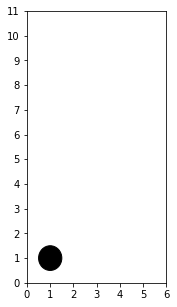

In [440]:
maxRows = 10
maxCols = 5
height = 5


aspRatio = maxCols/maxRows

    
fSize = (height*aspRatio,height)

f = plt.figure(figsize=(fSize[0],fSize[1]))
ax = plt.gca()
ax.set_yticks(np.arange(0,maxRows+2))
ax.set_xticks(np.arange(0,maxCols+2))

circle1=patches.Ellipse((1,1),
               width = 1,
               height = 1,    
               facecolor='k',
               edgecolor = 'k')


ax.add_artist(circle1)
plt.show()

In [620]:
emoji.emojize('Hi there! :thumbs_down:')

'Hi there! 👎'

['Motifs']
0.46153846153846156
(2, 12)
(3, 12)
(4, 12)


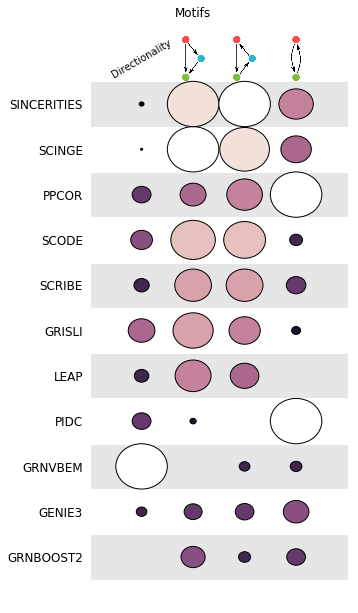

In [72]:
direcpath = 'Directionality.png'
mutpath = 'img/fancyMI.png'
cascpath = 'img/fancyFBL.png'
fflpath = 'img/fancyFFL.png'
pale = sns.diverging_palette(5, 230, center = 'light', n=10)
pale = sns.color_palette("mako",11)
pale1 = sns.color_palette("viridis",11)
pale2 = sns.cubehelix_palette(11, dark=1, light = 0)
datapath = 'motifRes.csv'
finalDF3 = pd.read_csv(datapath, header=[0,1],index_col = 0,skipinitialspace=True)
finalDF3 = finalDF3.loc[finalDF3.mean(axis='columns').sort_values().index]
colfigures = {'Motifs':{#'Directionality':direcpath,
                        'FFL':fflpath,
                        'Cascade':cascpath,
                        'Mutual':mutpath
                       }}
fancyDF(finalDF3, height = 10, randValues = [-2,0, 0.5,0.5,0,0], 
        shape = ['c','w'], palettes = [pale2],
        text = [False], 
        levels = ['Motifs'],
        rotation = [30,0,0,0,0],
        colfigures=colfigures,
        zoom=0.19)
